<a href="https://colab.research.google.com/github/TurkuNLP/intro-to-nlp/blob/master/intro_2023_exercise_8_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sequence labeling with CRF

This notebook provides an example of how to perform sequence labeling with a Conditional Random Field (CRF) model.

(This notebook is based on this [notebook for CoNLL 2002 Spanish tagging](https://github.com/TeamHG-Memex/sklearn-crfsuite/blob/master/docs/CoNLL2002.ipynb))

---

## Setup

We'll be using the [sklearn-crfsuite](https://sklearn-crfsuite.readthedocs.io/en/latest/) Python package, which wraps the [CRFsuite](http://www.chokkan.org/software/crfsuite/) CRF implementation.

(Specifically, we'll install a fork that fixes a [versioning incompatibility issue](https://github.com/TeamHG-Memex/sklearn-crfsuite/issues/60) with the integration)

In [1]:
!pip install --quiet git+https://github.com/MeMartijn/updated-sklearn-crfsuite.git#egg=sklearn_crfsuite

  Preparing metadata (setup.py) ... done


To take advantage of the integration of CRFsuite into the [scikit-learn](https://scikit-learn.org/stable/) machine learning library, we'll here be using parts of that library to support data loading and evaluation. (The basic functionality provided by this library is similar to what you could get from the `datasets` and `evaluate` libraries that you should know by now, and there's no need to try to memorize any of the specific details of these libraries.) 

In [2]:
from itertools import chain

import nltk
import sklearn
import scipy.stats
import sklearn.metrics

from nltk.corpus.reader import ConllCorpusReader

from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from sklearn_crfsuite.utils import flatten

---

## Load data

We'll use the CoNLL'03 English dataset, which you should be familiar with. We've placed the original data on dl.turkunlp.org, and can download with `wget` as usual: 

In [3]:
!wget -nc --quiet http://dl.turkunlp.org/TKO_7095_2023/eng.train
!wget -nc --quiet http://dl.turkunlp.org/TKO_7095_2023/eng.testa
!wget -nc --quiet http://dl.turkunlp.org/TKO_7095_2023/eng.testb

We'll use the NLTK `ConllCorpusReader` to read in the words, parts of speech and named entity "chunks"

In [4]:
train_data = ConllCorpusReader('', 'eng.train', ['words', 'pos', 'ignore', 'chunk'])
devel_data = ConllCorpusReader('', 'eng.testa', ['words', 'pos', 'ignore', 'chunk'])
test_data = ConllCorpusReader('', 'eng.testa', ['words', 'pos', 'ignore', 'chunk'])

# The comprehension here drops empty sentences used to denote document boundaries 
train_sentences = [s for s in train_data.iob_sents() if s]
devel_sentences = [s for s in devel_data.iob_sents() if s]
test_sentences = [s for s in devel_data.iob_sents() if s]

This reader returns a simple Python list representing the sentences, each of which is represented as a list of tuples of token features (form, POS tag, NE tag).

Note that unlike in `datasets`, the data is here in "human-readable" string form rather than as integer IDs.

In [5]:
train_sentences[0]

[('EU', 'NNP', 'I-ORG'),
 ('rejects', 'VBZ', 'O'),
 ('German', 'JJ', 'I-MISC'),
 ('call', 'NN', 'O'),
 ('to', 'TO', 'O'),
 ('boycott', 'VB', 'O'),
 ('British', 'JJ', 'I-MISC'),
 ('lamb', 'NN', 'O'),
 ('.', '.', 'O')]

---

## Create features

Here a very basic function that returns explicitly defined features for a token

```
Initial           : micro avg       0.86      0.83      0.84      8603
+ token.lower()   : micro avg       0.87      0.84      0.86      8603
+ window_size=1   : micro avg       0.90      0.86      0.88      8603
+ window_size=2   : micro avg       0.91      0.86      0.88      8603
+ BOS and EOS     : micro avg       0.91      0.86      0.88      8603
+ token prefixes  : micro avg       0.91      0.87      0.89      8603
+ token suffixes  : micro avg       0.91      0.88      0.89      8603
+ hyperparams     : micro avg      0.914     0.878     0.896      8603  
```

In [6]:
def token_features(tokens, index):
    features = {
        'bias': 1.0,
    }

    window_size = 2
    start = max(0, index-window_size)
    end = min(len(tokens)-1, index+window_size)

    if start > index-window_size:
        features['BOS'] = True
    if end < index+window_size:
        features['EOS'] = True

    for i in range(start, end+1):
        o = i - index
        token = tokens[i][0]
        pos_tag = tokens[i][1]
        features.update({
            f'token[{o}].text()': token,
            f'token[{o}].lower()': token.lower(),       
            f'token[{o}].istitle()': token.istitle(),
            f'token[{o}].isdigit()': token.isdigit(),
            f'pos_tag[{o}]': pos_tag,
        })

    for i in range(2, 4):
        features.update({
            f'token[0].text()[:{i}]': tokens[index][0][:i],
            f'token[0].text()[{-i}:]': tokens[index][0][-i:],
        })

    return features

Some convenience functions to get features for all tokens in a sentence as well as all labels and all token texts.

In [7]:
def sentence_features(tokens):
    return [token_features(tokens, i) for i in range(len(tokens))]

def sentence_labels(tokens):
    return [label for token, postag, label in tokens]

def sentence_tokens(tokens):
    return [token for token, postag, label in tokens]

Check features for a single token

In [8]:
sentence_features(train_sentences[0])[0]

{'bias': 1.0,
 'BOS': True,
 'token[0].text()': 'EU',
 'token[0].lower()': 'eu',
 'token[0].istitle()': False,
 'token[0].isdigit()': False,
 'pos_tag[0]': 'NNP',
 'token[1].text()': 'rejects',
 'token[1].lower()': 'rejects',
 'token[1].istitle()': False,
 'token[1].isdigit()': False,
 'pos_tag[1]': 'VBZ',
 'token[2].text()': 'German',
 'token[2].lower()': 'german',
 'token[2].istitle()': True,
 'token[2].isdigit()': False,
 'pos_tag[2]': 'JJ',
 'token[0].text()[:2]': 'EU',
 'token[0].text()[-2:]': 'EU',
 'token[0].text()[:3]': 'EU',
 'token[0].text()[-3:]': 'EU'}

Get features and labels for training and development data

In [9]:
X_train = [sentence_features(s) for s in train_sentences]
y_train = [sentence_labels(s) for s in train_sentences]

X_devel = [sentence_features(s) for s in devel_sentences]
y_devel = [sentence_labels(s) for s in devel_sentences]

---

## Train and evaluate model

Instantiate CRF. For details on the model hyperparameters, see the [CRFsuite documentation](https://www.chokkan.org/software/crfsuite/).

In [10]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    c1=0.1, 
    c2=0.1, 
    max_iterations=100, 
    all_possible_transitions=True
)

Train the model

In [11]:
crf.fit(X_train, y_train)

CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    max_iterations=100)

Get set of POS tags for evaluation, excluding the "Out" tag `O`

In [12]:
labels = list(crf.classes_)
labels.remove('O')
labels

['I-ORG', 'I-MISC', 'I-PER', 'I-LOC', 'B-LOC', 'B-MISC', 'B-ORG']

Predict labels for development set

In [13]:
y_pred = crf.predict(X_devel)

Evaluate predictions against gold standard development set labels

In [14]:
sorted_labels = sorted(labels, key=lambda name: (name[1:], name[0]))

print(sklearn.metrics.classification_report(
    flatten(y_devel),
    flatten(y_pred),
    labels=sorted_labels
))

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1

              precision    recall  f1-score   support

       B-LOC       0.00      0.00      0.00         0
       I-LOC       0.92      0.88      0.90      2094
      B-MISC       0.00      0.00      0.00         4
      I-MISC       0.91      0.83      0.87      1264
       B-ORG       0.00      0.00      0.00         0
       I-ORG       0.87      0.83      0.85      2092
       I-PER       0.93      0.93      0.93      3149

   micro avg       0.91      0.88      0.89      8603
   macro avg       0.52      0.49      0.51      8603
weighted avg       0.91      0.88      0.89      8603



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


---

## Analyze classifier

We can look at `transition_features_` to analyze the transition weights learned by the model:

In [15]:
from collections import Counter

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Most likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(10))

print("\nLeast likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-10:])

Most likely transitions:
I-MISC -> B-MISC  3.727991
I-ORG  -> I-ORG   3.661494
I-LOC  -> I-LOC   3.314899
I-MISC -> I-MISC  3.063793
I-PER  -> I-PER   3.044030
I-LOC  -> B-LOC   2.936341
B-ORG  -> B-ORG   2.813874
B-MISC -> I-MISC  2.259211
O      -> O       2.077222
O      -> I-PER   0.734798

Least likely transitions:
I-MISC -> I-ORG   -1.980208
I-ORG  -> I-MISC  -2.190352
I-MISC -> I-LOC   -2.605446
I-LOC  -> I-ORG   -2.804579
I-PER  -> I-MISC  -2.833085
I-PER  -> I-LOC   -3.140030
I-LOC  -> I-PER   -3.397410
I-ORG  -> I-PER   -3.611332
I-PER  -> I-ORG   -3.990547
I-ORG  -> I-LOC   -4.026007


Similarly, we can look at `state_features_` to look at the probabilities of the explicit features we introduced:

In [16]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))    

print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(10))

print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-10:])

Top positive:
5.504126 O        token[0].text()[-3:]:day
4.715026 I-MISC   pos_tag[0]:$
4.225288 I-PER    token[0].text()[:2]:Mc
3.850501 O        token[0].text()[:3]:Sep
3.712716 I-LOC    token[-1].text():Colo
3.712716 I-LOC    token[-1].lower():colo
3.704106 O        token[0].text()[:3]:Aug
3.622298 I-ORG    token[0].text()[-2:]:EC
3.610589 O        bias
3.440807 O        token[0].text()[:2]:W1

Top negative:
-2.604805 I-ORG    token[0].isdigit()
-2.621656 B-LOC    bias
-2.621730 O        token[0].text()[-2:]:TO
-2.642925 O        pos_tag[0]:NNPS
-2.656006 B-MISC   bias
-2.771128 O        token[0].text()[:2]:Ro
-2.938220 O        token[-1].lower():moody
-2.947140 O        token[0].text()[-2:]:AN
-3.125447 I-LOC    token[1].isdigit()
-3.216320 O        token[0].istitle()


---

## Hyperparameter optimization

(This part of the notebook is copied directly from the [notebook for CoNLL 2002 Spanish tagging](https://github.com/TeamHG-Memex/sklearn-crfsuite/blob/master/docs/CoNLL2002.ipynb))

In [17]:
%%time

# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    max_iterations=100, 
    all_possible_transitions=True
)

param_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(
    metrics.flat_f1_score,
    average='weighted',
    labels=labels
)

# search
rs = RandomizedSearchCV(
    crf,
    param_space, 
    cv=3, 
    verbose=1, 
    n_jobs=-1, 
    n_iter=50, 
    scoring=f1_scorer
)

rs.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
CPU times: user 13min 16s, sys: 1min 33s, total: 14min 50s
Wall time: 1h 28min 29s


RandomizedSearchCV(cv=3,
                   estimator=CRF(algorithm='lbfgs',
                                 all_possible_transitions=True,
                                 max_iterations=100),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f4340460670>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f43403e7580>},
                   scoring=make_scorer(flat_f1_score, average=weighted, labels=['I-ORG', 'I-MISC', 'I-PER', 'I-LOC', 'B-LOC', 'B-MISC', 'B-ORG']),
                   verbose=1)

In [18]:
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.010029012775409568, 'c2': 0.008364141984784803}
best CV score: 0.8646890591997062
model size: 4.10M


### Visualize parameter space

In [19]:
rs.cv_results_

{'mean_fit_time': array([68.2450858 , 67.80299457, 68.41943558, 68.43861198, 67.9520479 ,
        66.79955355, 63.85548536, 61.96898826, 62.19432608, 58.81479526,
        59.0412159 , 58.96159983, 60.95325788, 60.7336607 , 59.20995005,
        60.07738511, 58.86902014, 61.16866191, 59.57398629, 60.25752775,
        58.63062215, 61.52501186, 60.47810594, 59.96968691, 63.812977  ,
        59.61794146, 60.51773938, 61.33904624, 64.46386806, 64.85921327,
        68.82925518, 69.18700345, 69.29359929, 73.35335294, 62.35595926,
        62.5009702 , 61.34446232, 62.37624351, 61.65433526, 61.7156326 ,
        60.51364295, 59.38689558, 59.10955691, 59.51269635, 62.07210716,
        62.83765093, 60.63622244, 62.09839781, 61.06899865, 55.96699484]),
 'std_fit_time': array([3.47226247, 6.36591669, 3.04548495, 7.11084989, 5.11464527,
        6.50226437, 7.27822239, 4.91877775, 4.80440044, 4.58468373,
        3.79630157, 5.1388931 , 3.88309341, 5.81784906, 1.90163441,
        5.5680909 , 5.17460007,

In [20]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.style.use('ggplot')

Dark blue => 0.8039, dark red => 0.8647


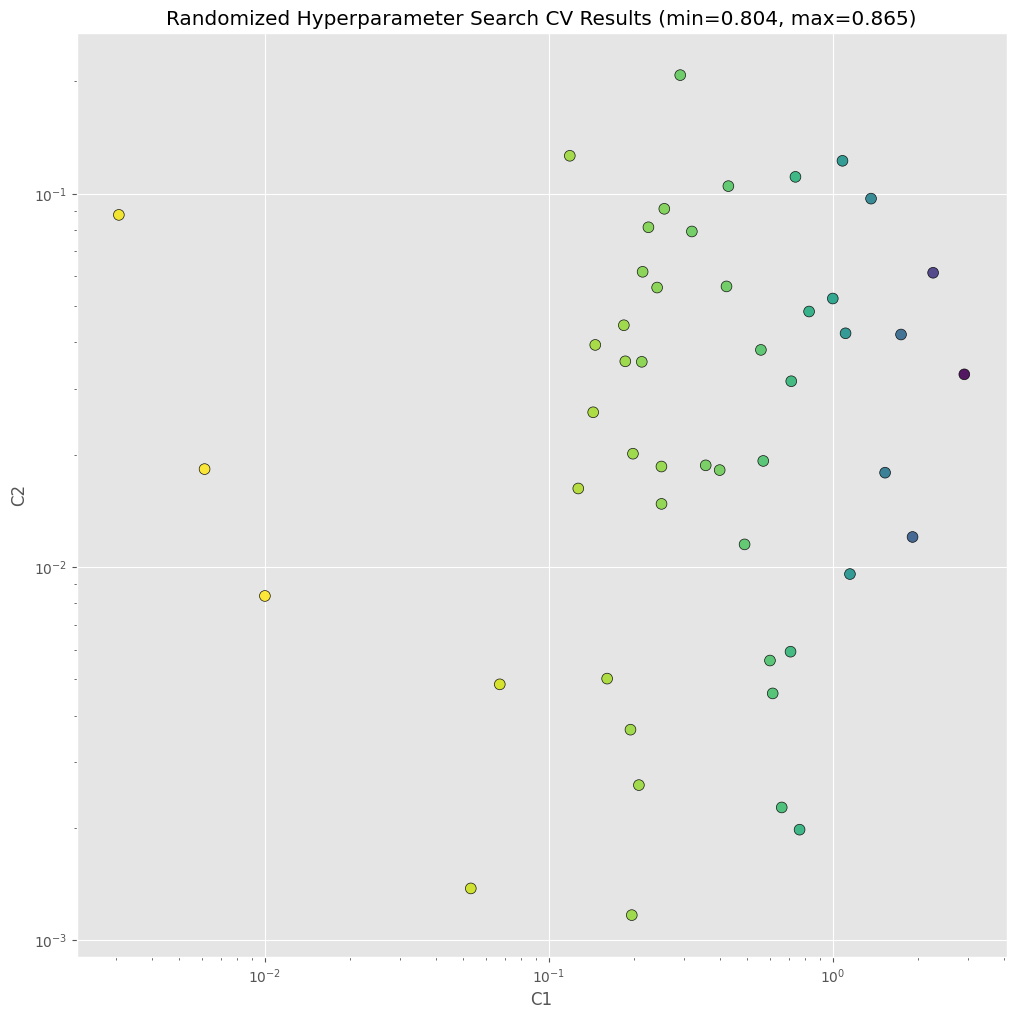

In [21]:
_x = [s['c1'] for s in rs.cv_results_['params']]
_y = [s['c2'] for s in rs.cv_results_['params']]
_c = [s for s in rs.cv_results_['mean_test_score']]

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

In [22]:
crf = rs.best_estimator_

y_pred = crf.predict(X_devel)

print(metrics.flat_classification_report(
    y_devel, y_pred, labels=sorted_labels, digits=3
))

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1

              precision    recall  f1-score   support

       B-LOC      0.000     0.000     0.000         0
       I-LOC      0.915     0.884     0.900      2094
      B-MISC      0.250     0.250     0.250         4
      I-MISC      0.910     0.828     0.867      1264
       B-ORG      0.000     0.000     0.000         0
       I-ORG      0.874     0.833     0.853      2092
       I-PER      0.942     0.925     0.934      3149

   micro avg      0.914     0.878     0.896      8603
   macro avg      0.556     0.532     0.543      8603
weighted avg      0.914     0.878     0.896      8603



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
